In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from models import create_model 
import pandas as pd

import yaml
import torch
from pipeline.walkforward import WFCVGenerator
from utils.paths import CONFIG_DIR, VOL_EXPERIMENTS_DIR, DATA_DIR, PRICE_EXPERIMENTS_DIR

from config.config_types import AppConfig


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import json


In [3]:

fold_num = 0
name = "exp_001_mlp_40_sliding"
name = "exp_010_cnn_40_sliding"
name = "exp_006_cnn_40"
name = "exp_012_cnn_40"
name = "exp_011_mlp_40"
name = "exp_013_mlp_504"
name = "exp_011_mlp_40"

name  = "exp_012_lstm_40"
name  = "exp_017_debug"
trial = "trial_20251108_145907" 
trial = "trial_20251108_010740" 

# -------- load config --------
base = f"{VOL_EXPERIMENTS_DIR}/{name}/{trial}/"
conifg_path = f"{base}config_snapshot.json"

with open(conifg_path, 'r') as f:
    cfg = json.load(f)

cfg = cfg["cfg"]

cfg = AppConfig.from_dict(cfg)

if cfg.data["df_master"] is not None:
    df_master_path =  cfg.data["df_master"]
    df_master = pd.read_parquet(f"{DATA_DIR}/{df_master_path}")
    #print(f"provided df master: {df_master_path}\n{df_master.head()}")
else:
    df_master = None

wf = WFCVGenerator(config=cfg.walkforward)


In [4]:
results = pd.read_csv(f"{base}/results.csv")
results


,trial,fold,tr_loss,val_loss,test_loss,tr_mae,val_mae,test_mae,tr_directional_accuracy_pct,val_directional_accuracy_pct,test_directional_accuracy_pct,seconds,model_path
0,0,0,0.43046,0.423086,0.379629,0.510972,0.505036,0.482202,78.274624,77.894052,73.287476,2915.541626,/orcd/home/002/corte911/code/finNN_code/src/vo...


In [5]:
results.drop(columns="model_path").mean().apply(lambda x: round(x, 5))

trial                               0.00000
fold                                0.00000
tr_loss                             0.43046
val_loss                            0.42309
test_loss                           0.37963
tr_mae                              0.51097
val_mae                             0.50504
test_mae                            0.48220
tr_directional_accuracy_pct        78.27462
val_directional_accuracy_pct       77.89405
test_directional_accuracy_pct      73.28748
seconds                          2915.54163
dtype: float64

In [6]:

test_data = {}
data = {}
for i, fold_data in enumerate(wf.folds()):
    X_test = fold_data[4]
    y_test = fold_data[5]

    test_data[i] = [X_test, y_test]
    data[i] = fold_data
    print(i)
    #if i == fold_num:
    #    break


0


In [7]:


hparams = cfg.model.hparams
input_shape = (cfg.walkforward.lags,)
output_shape = cfg.walkforward.lookback+1

ckpt_path = f"{base}fold_{fold_num:03d}/model_best.pt"
checkpoint = torch.load(ckpt_path, map_location="cuda")




In [8]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

sns.set_theme(style="darkgrid", context="talk")

def maybe_inverse(y, scaler):
    return y if scaler is None else scaler.inverse_transform(y.reshape(-1,1)).ravel()





def plot_split_dims(title, y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Ensure 2D: (N,) -> (N,1)
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
    N, K = y_true.shape

    # --- single-output: keep your original style ---
    if K == 1:
        yt = y_true[:, 0]
        yp = y_pred[:, 0]

        # fit + metrics
        reg = LinearRegression().fit(yt.reshape(-1,1), yp)
        slope, intercept = reg.coef_[0], reg.intercept_
        r2 = r2_score(yt, yp)
        rmse = np.sqrt(mean_squared_error(yt, yp))
        score = np.mean(yt < yp)
        print(f"Score: {score}")

        # min/max limits (with small padding)
        low = min(yt.min(), yp.min())
        high = max(yt.max(), yp.max())
        #vals = np.concatenate([yt.ravel(), yp.ravel()])
        #low, high = np.percentile(vals, [5, 95])
        pad = 0.02 * (high - low)
        low -= pad; high += pad

        x_line = np.linspace(low, high, 200)
        y_line = reg.predict(x_line.reshape(-1,1))

        # scatter + fit
        plt.figure(figsize=(10,8))
        plt.scatter(yt, yp, s=8, alpha=0.5, edgecolors="none")
        plt.plot([low, high], [low, high], 'k--', lw=1, label="45° line")
        plt.plot(x_line, y_line, 'r-', lw=2, label=f'Fit: y={slope:.3f}x+{intercept:.3f}')
        plt.title(f"{title} — R²={r2:.5f}, RMSE={rmse:.5g}")
        plt.xlabel("True"); plt.ylabel("Predicted")
        plt.xlim(low, high); plt.ylim(low, high)
        plt.legend(); plt.tight_layout(); plt.show()

        # KDEs
        plt.figure(figsize=(8,5))
        sns.kdeplot(yt, fill=True, alpha=0.5, label="True", linewidth=2)
        sns.kdeplot(yp, fill=True, alpha=0.5, label="Predicted", linewidth=2)
        plt.title(f"Distributions — {title}")
        plt.xlabel("Value"); plt.ylabel("Density")
        plt.xlim(low, high)
        plt.legend(); plt.tight_layout(); plt.show()
        return

    # --- multi-output: grid of subplots (one per dimension) ---
    ncols = min(3, K)                     # up to 3 columns wide
    nrows = math.ceil(K / ncols)

    fig_scatter, axes_s = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows), squeeze=False)

    for j in range(K):
        r, c = divmod(j, ncols)
        ax = axes_s[r, c]

        yt = y_true[:, j]
        yp = y_pred[:, j]
        perc = (yt > yp).mean() * 100
        print(f'percentage: {perc:.4f}')

        reg = LinearRegression().fit(yt.reshape(-1,1), yp)
        slope, intercept = reg.coef_[0], reg.intercept_
        r2 = r2_score(yt, yp)
        rmse = np.sqrt(mean_squared_error(yt, yp))

        low = min(yt.min(), yp.min())
        high = max(yt.max(), yp.max())
        #vals = np.concatenate([yt.ravel(), yp.ravel()])
        #low, high = np.percentile(vals, [2.5, 97.5])

        pad = 0.02 * (high - low)
        low -= pad; high += pad

        x_line = np.linspace(low, high, 200)
        y_line = reg.predict(x_line.reshape(-1,1))

        ax.scatter(yt, yp, s=8, alpha=0.5, edgecolors="none")
        ax.plot([low, high], [low, high], 'k--', lw=1, label="45° line")
        ax.plot(x_line, y_line, 'r-', lw=2, label=f'Fit: y={slope:.3f}x+{intercept:.3f}')
        ax.set_title(f"Dim {j} — R²={r2:.5f}, RMSE={rmse:.5g}")
        ax.set_xlabel("True"); ax.set_ylabel("Predicted")
        ax.set_xlim(low, high); ax.set_ylim(low, high)
        ax.legend(loc="best")

    # Hide any unused axes
    for j in range(K, nrows*ncols):
        r, c = divmod(j, ncols)
        fig_scatter.delaxes(axes_s[r, c])

    fig_scatter.suptitle(f"{title} — Scatter & Fit per Dimension", y=0.995, fontsize=14)
    fig_scatter.tight_layout()
    plt.show()

    # --- optional: KDE grid per dimension ---
    fig_kde, axes_k = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows), squeeze=False)
    for j in range(K):
        r, c = divmod(j, ncols)
        ax = axes_k[r, c]
        yt = y_true[:, j]; yp = y_pred[:, j]
        low = min(yt.min(), yp.min()); high = max(yt.max(), yp.max())
        pad = 0.02 * (high - low); low -= pad; high += pad

        sns.kdeplot(yt, fill=True, alpha=0.5, label="True", linewidth=2, ax=ax)
        sns.kdeplot(yp, fill=True, alpha=0.5, label="Predicted", linewidth=2, ax=ax)
        ax.set_title(f"KDE — Dim {j}")
        ax.set_xlabel("Value"); ax.set_ylabel("Density")
        ax.set_xlim(low, high)
        ax.legend(loc="best")

    for j in range(K, nrows*ncols):
        r, c = divmod(j, ncols)
        fig_kde.delaxes(axes_k[r, c])

    fig_kde.suptitle(f"Distributions — {title}", y=0.995, fontsize=14)
    fig_kde.tight_layout()
    plt.show()

def _infer_lstm_input_size_from_ckpt(state_dict: dict) -> int | None:
    # look for first LSTM weight_ih
    for k, v in state_dict.items():
        if k.endswith("lstm_layers.0.weight_ih_l0") or ("lstm_layers.0.weight_ih_l0" in k):
            # shape is [4*H, input_size]
            return int(v.shape[1])
    # legacy single-module naming (if any)
    for k, v in state_dict.items():
        if k.endswith("lstm.weight_ih_l0") or ("lstm.weight_ih_l0" in k):
            return int(v.shape[1])
    return None

def _make_input_shape_for_eval(cfg, X_sample: torch.Tensor | np.ndarray, state_dict: dict):
    name = cfg.model.name.lower()
    # infer T and (optional) D from the data
    if isinstance(X_sample, np.ndarray):
        shape = X_sample.shape
    else:
        shape = tuple(X_sample.shape)
    # shape is typically (N, T) or (N, T, D)
    if len(shape) == 2:
        _, T = shape
        D_data = 1
    elif len(shape) == 3:
        _, T, D_data = shape
    else:
        raise ValueError(f"Unexpected batch shape for X: {shape}")

    if name == "lstm":
        D_ckpt = _infer_lstm_input_size_from_ckpt(state_dict)
        D = D_ckpt if D_ckpt is not None else D_data  # prefer ckpt
        return (T, D)
    elif name == "simplecnn":
        # your CNN expects (C, L) with C=1
        return (1, T)
    elif name == "mlp":
        # your MLP code expects (T,) as before (flattened window)
        return (T,)
    else:
        raise ValueError(f"Unknown model name: {cfg.model.name}")

@torch.inference_mode()
def _predict_batched(model, X, device="cuda", bs=8192):
    preds = []
    for i in range(0, len(X), bs):
        xb = torch.as_tensor(X[i:i+bs], dtype=torch.float32, device=device)
        pb = model(xb).detach().cpu()
        preds.append(pb)
    return torch.cat(preds, dim=0).numpy()

def eval_and_plot_simple(cfg, input_shape, output_shape, ckpt, datasets, device="cuda"):
    Xtr, ytr, Xv, yv, Xte, yte = datasets

    # strip compile prefix if present
    state_dict = {k.replace("_orig_mod.", ""): v for k, v in ckpt["model_state"].items()}

    # build the **correct** input_shape for this checkpoint + data
    input_shape = _make_input_shape_for_eval(cfg, Xtr, state_dict)

    # (optional) infer output_dim from head if you want to be robust
    # otherwise keep your existing output_shape
    # try to find last linear in head
    out_dim = None
    for k, v in state_dict.items():
        if k.startswith("head.") and k.endswith(".weight"):
            if out_dim is None or v.shape[0] < out_dim:
                out_dim = int(v.shape[0])
    if out_dim is not None:
        output_shape = out_dim

    def make_input_shape(c):
        if cfg.model.name.lower() == "mlp":
            return (c.walkforward.lags, )
        elif cfg.model.name.lower() == "simplecnn":
            return (1, cfg.walkforward.lags)  # (C, L)
        elif cfg.model.name.lower() == "lstm":
            return (cfg.walkforward.lags, 1)
        else:
            print(f"Model: {cfg.model.name} not recognized!")
            raise ValueError

    # ouput shape is constant
    output_shape = cfg.walkforward.lookback + 1 if cfg.walkforward.lookback is not None else 1

    # rebuild & load model
    model = create_model(cfg.model, input_shape, output_shape)
    model.load_state_dict(state_dict, strict=True)
    model.to(device).eval()

    # predictions (batched to avoid OOM)
    yhat_tr = _predict_batched(model, Xtr, device=device, bs=8192)
    yhat_v  = _predict_batched(model, Xv,  device=device, bs=8192)
    yhat_te = _predict_batched(model, Xte, device=device, bs=8192)

    # numpy true arrays
    ytr = np.asarray(ytr, dtype=np.float32)
    yv  = np.asarray(yv,  dtype=np.float32)
    yte = np.asarray(yte, dtype=np.float32)

    print("Train", ytr.shape, yhat_tr.shape)
    plot_split_dims("Train",      ytr, yhat_tr)
    plot_split_dims("Validation", yv,  yhat_v)
    plot_split_dims("Test",       yte, yhat_te)

    return model, (ytr, yhat_tr), (yv, yhat_v), (yte, yhat_te)


Train (1723450,) (1723450, 1)
Score: 0.5095831036583597


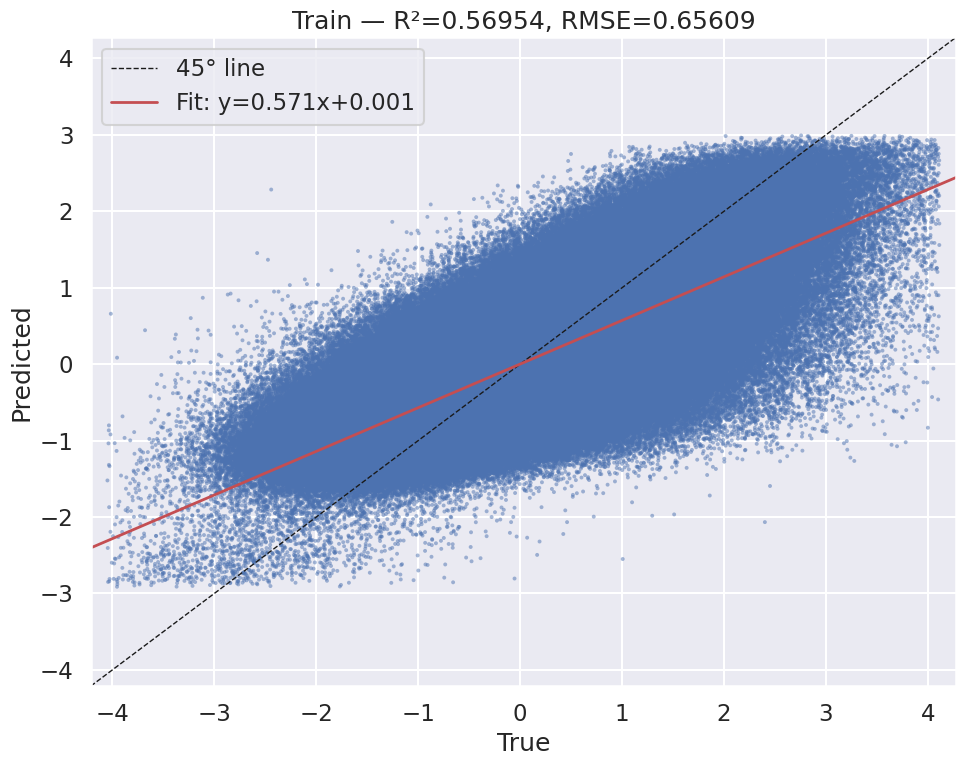

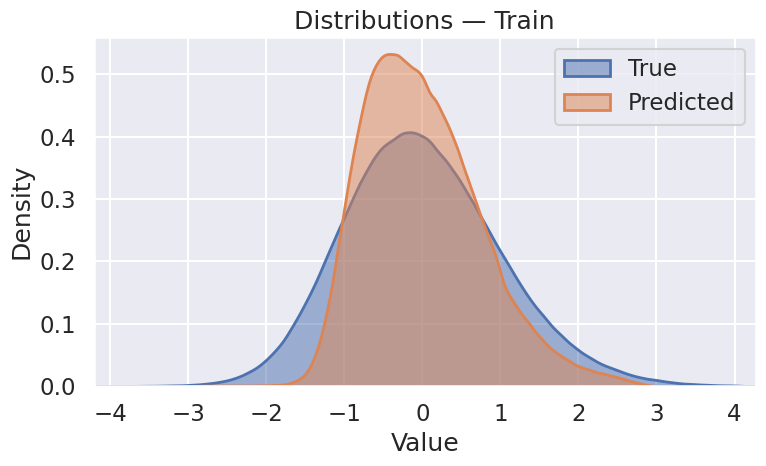

Score: 0.5219152809036327


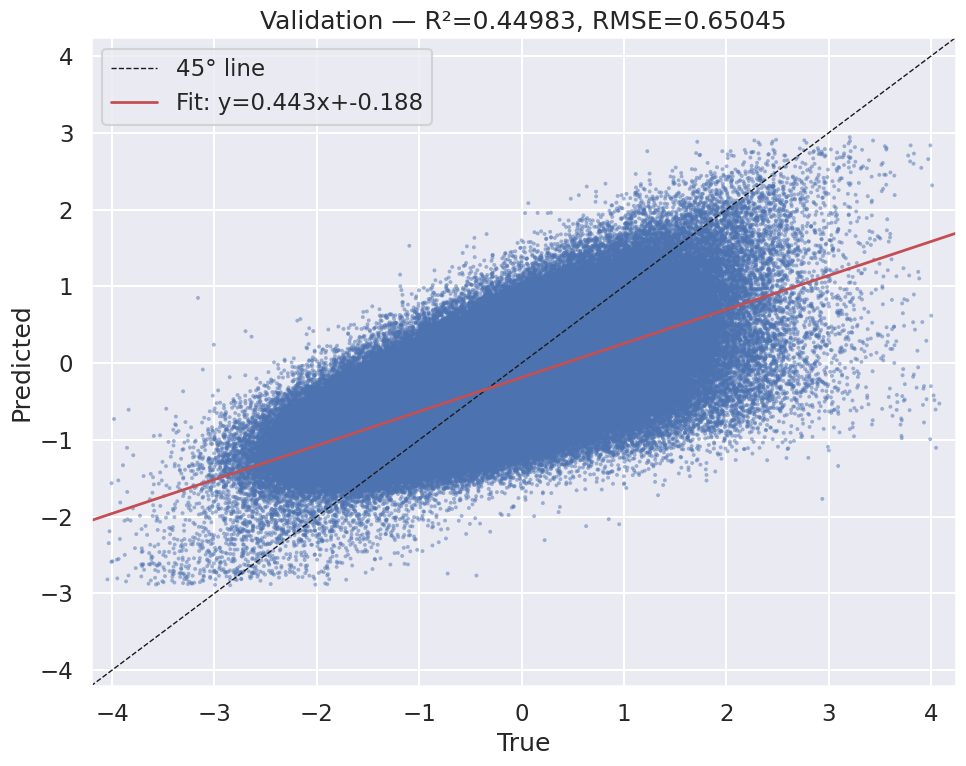

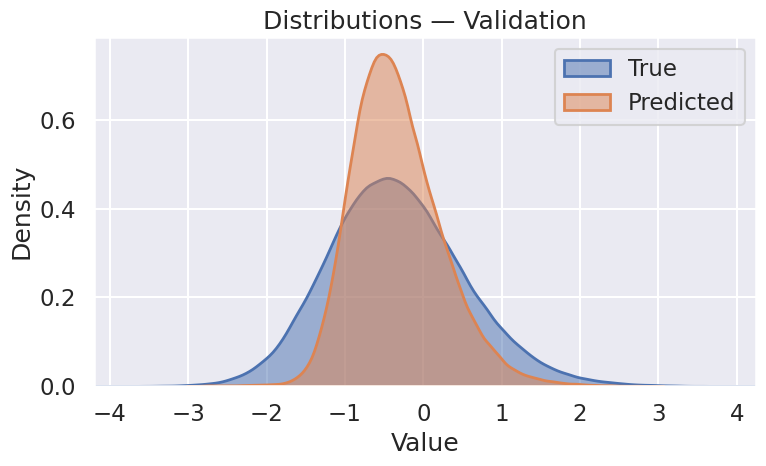

Score: 0.5074212767464301


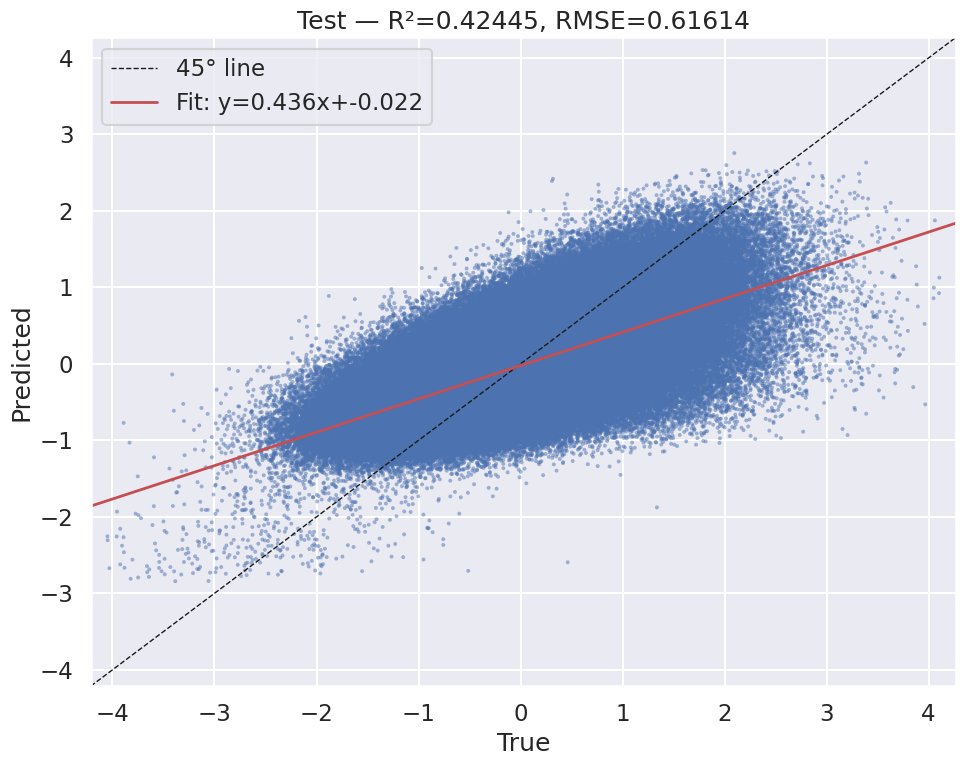

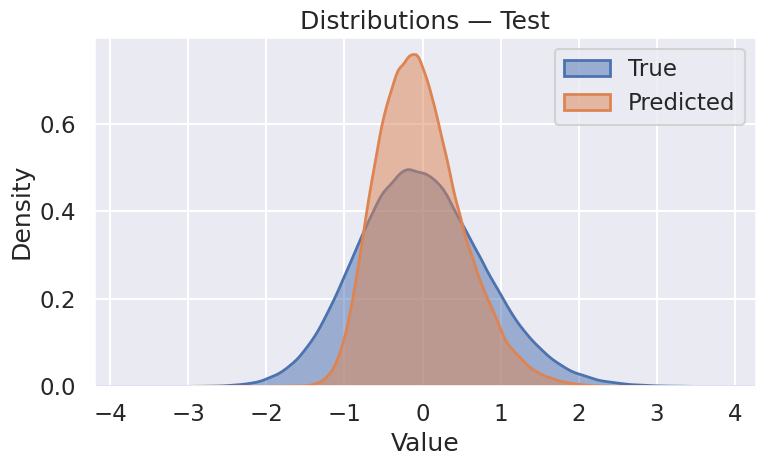

In [9]:
# old lines (now simplified)
model, trdata, vdata, tedata = eval_and_plot_simple(
    cfg,
    input_shape=None,         # you can even pass None now — it’s inferred
    output_shape=None,        # optional, inferred if missing
    ckpt=checkpoint,
    datasets=data[fold_num],
    device="cuda"
)


In [10]:
fold = 0
while True:    
    print("-"*50)
    print(f'fold: {fold}')
    try:
        for arr in data[fold]:
            print(f"{np.mean(arr):.4f}, {np.std(arr):.4f}, {np.percentile(arr, q=[0.05, 0.25, 0.5, 0.75, 0.95])},{np.min(arr):.4f}, {np.max(arr):.4f}")
        fold +=1
    except KeyError:
        break

--------------------------------------------------
fold: 0
0.0000, 1.0000, [-2.945663   -2.50181838 -2.30517383 -2.18668114 -2.1139623 ],-4.0717, 4.1226
-0.0000, 1.0000, [-3.09036938 -2.54797288 -2.3281023  -2.20328767 -2.12571384],-4.0488, 4.1117
-0.3656, 0.8679, [-2.97929538 -2.57900531 -2.4049193  -2.29714647 -2.23261163],-4.0515, 4.0925
-0.3411, 0.8769, [-3.12714452 -2.6360632  -2.43125094 -2.31488351 -2.24304854],-4.0454, 4.0818
0.0028, 0.8413, [-2.49396489 -2.12877774 -1.9636616  -1.86161541 -1.79931495],-4.0707, 4.1151
-0.0217, 0.8121, [-2.63768672 -2.15024772 -1.96669317 -1.86359685 -1.79732928],-4.0490, 4.1042
--------------------------------------------------
fold: 1


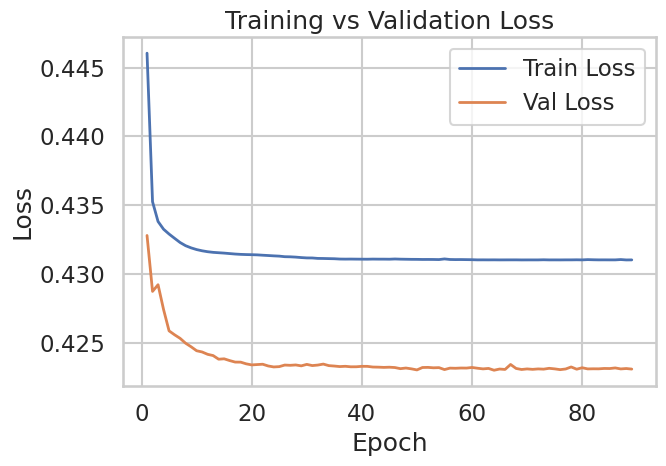

In [11]:
def plot_training_history(ckpt):
    """Plot train vs validation loss curves from the saved checkpoint."""
    history = ckpt.get("history", None)
    if not history:
        print("No training history found in checkpoint.")
        return

    # Convert list of dicts to separate arrays
    tr_losses = [h["tr_loss"] for h in history]
    val_losses = [h["val_loss"] for h in history]
    epochs = np.arange(1, len(tr_losses) + 1)

    sns.set_theme(style="whitegrid", context="talk")
    plt.figure(figsize=(7,5))
    plt.plot(epochs, tr_losses, label="Train Loss", lw=2)
    plt.plot(epochs, val_losses, label="Val Loss", lw=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(checkpoint)

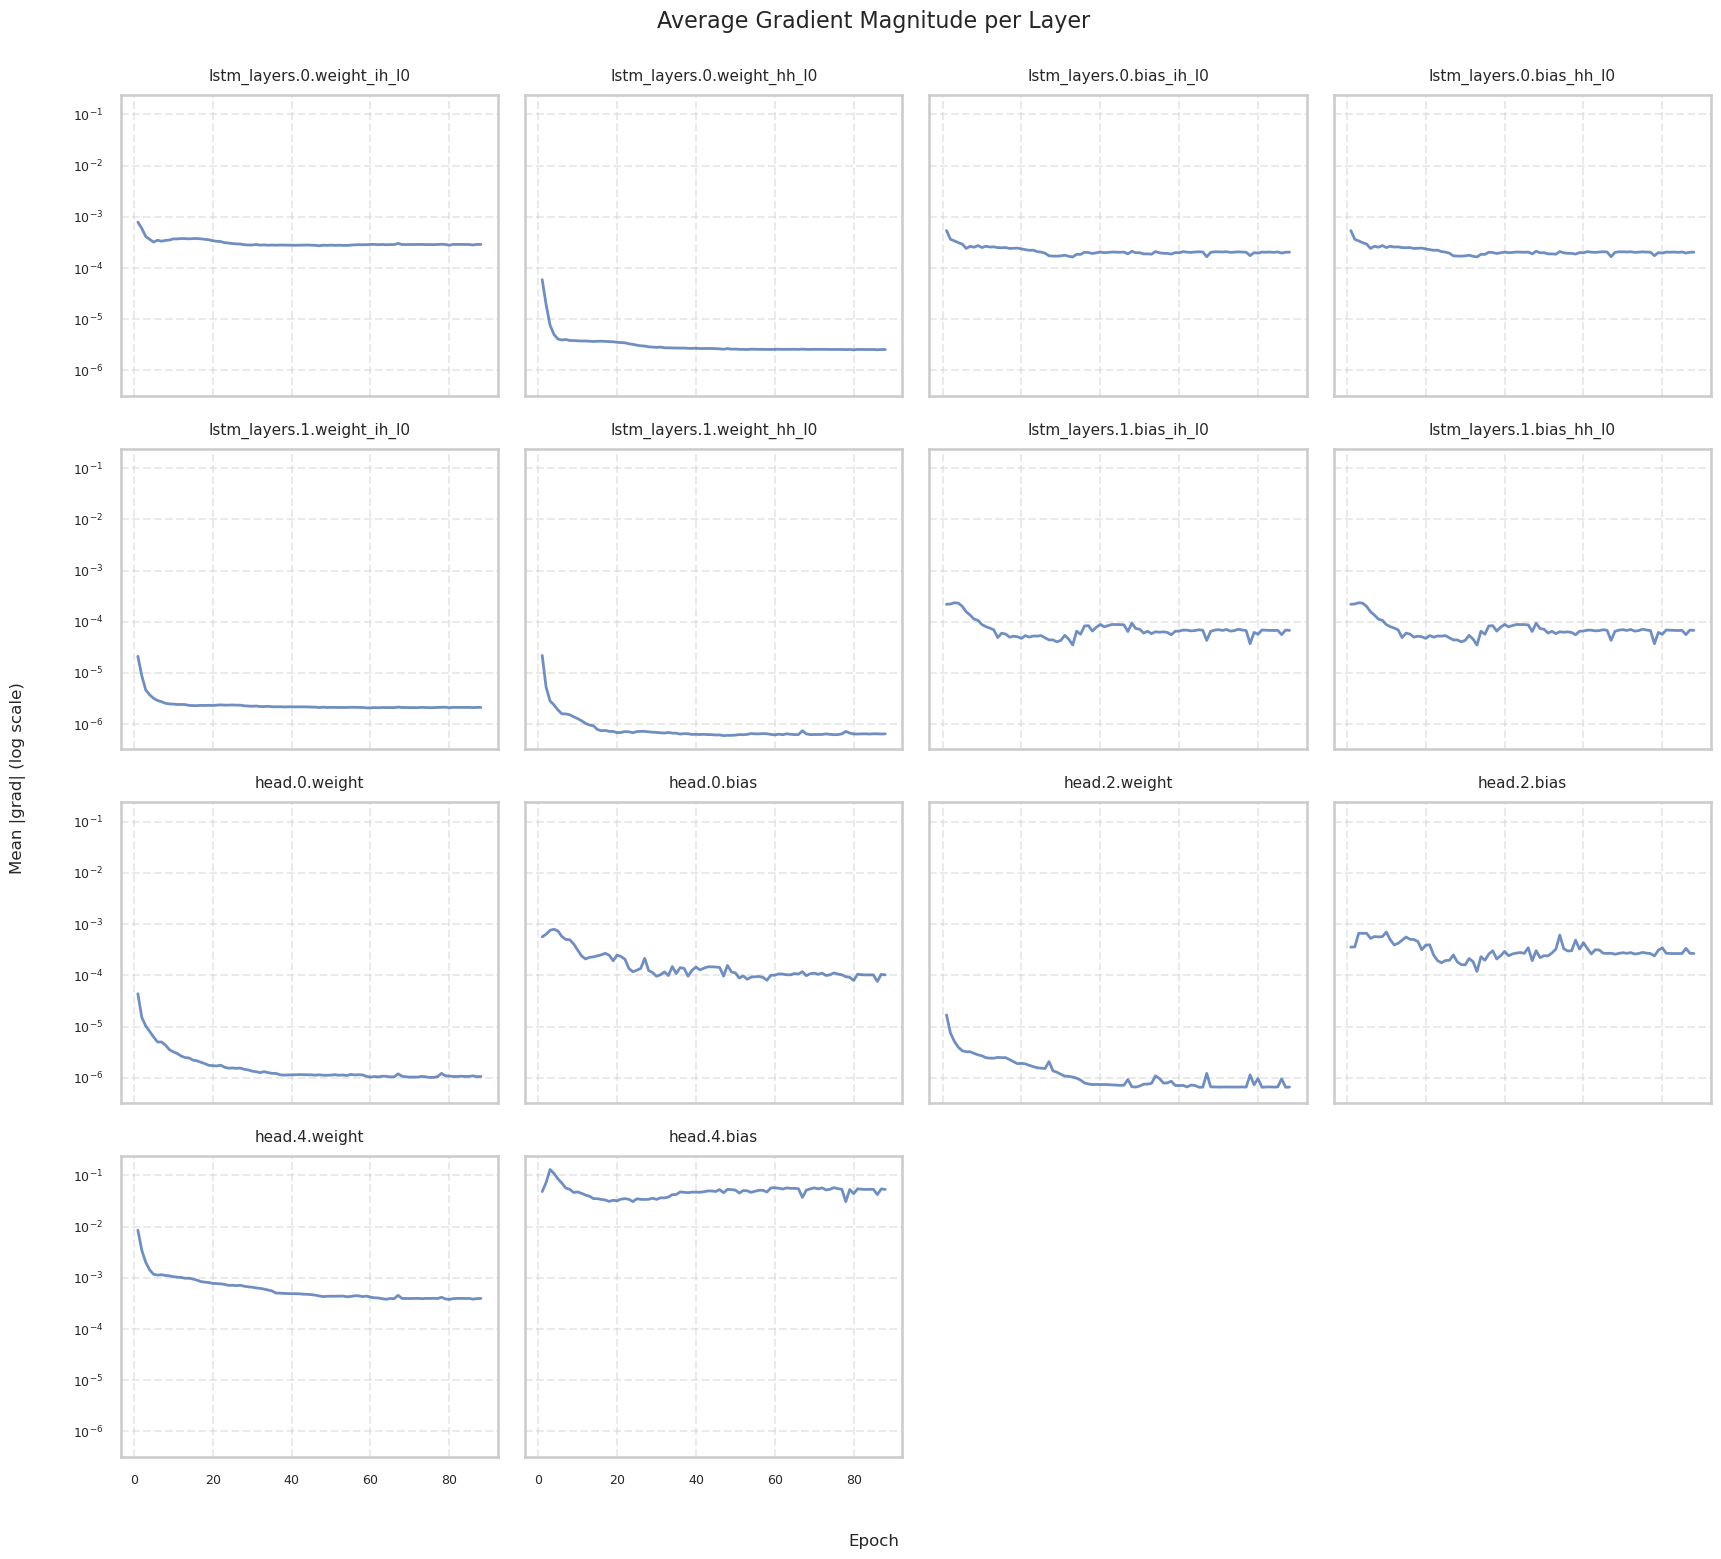

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import math

def plot_grad(ckpt):
    grad_history = ckpt.get("grad_history", [])
    if not grad_history:
        print("No grad_history found in checkpoint.")
        return

    df = pd.DataFrame(grad_history)
    if "epoch" not in df.columns:
        print("No 'epoch' column found in grad_history.")
        return

    df.set_index("epoch", inplace=True)
    
    # Clean column names for display (remove prefixes like _orig_mod.)
    df.columns = [c.replace("_orig_mod.", "") for c in df.columns]

    # --- grid setup ---
    n_cols = 4
    n_layers = len(df.columns)
    n_rows = math.ceil(n_layers / n_cols)

    # Increase figure size and adjust spacing
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        ax = axes[i]
        ax.plot(df.index, df[col], lw=2, alpha=0.8)
        ax.set_title(col, fontsize=11, pad=10)
        ax.set_yscale("log")
        ax.grid(True, linestyle="--", alpha=0.4)
        
        # Improve tick label formatting
        ax.tick_params(axis='both', which='major', labelsize=9)
        ax.tick_params(axis='both', which='minor', labelsize=7)
    
    # Hide empty tiles if #layers < grid size
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout with more padding
    plt.tight_layout(rect=[0.04, 0.04, 0.98, 0.96])  # [left, bottom, right, top]
    
    # Add titles with proper positioning
    fig.suptitle("Average Gradient Magnitude per Layer", fontsize=16, y=0.98)
    fig.text(0.5, 0.02, "Epoch", ha="center", fontsize=12)
    fig.text(0.02, 0.5, "Mean |grad| (log scale)", va="center", rotation="vertical", fontsize=12)
    
    plt.show()

plot_grad(checkpoint)

In [13]:
ckpt = checkpoint
grad_history = ckpt.get("grad_history", [])

df = pd.DataFrame(grad_history)

df.set_index("epoch", inplace=True)

# Clean column names for display (remove prefixes like _orig_mod.)
df.columns = [c.replace("_orig_mod.", "") for c in df.columns]
df


,lstm_layers.0.weight_ih_l0,lstm_layers.0.weight_hh_l0,lstm_layers.0.bias_ih_l0,lstm_layers.0.bias_hh_l0,lstm_layers.1.weight_ih_l0,lstm_layers.1.weight_hh_l0,lstm_layers.1.bias_ih_l0,lstm_layers.1.bias_hh_l0,head.0.weight,head.0.bias,head.2.weight,head.2.bias,head.4.weight,head.4.bias
epoch,,,,,,,,,,,,,,
1,0.000789,0.000059,0.000540,0.000540,0.000021,2.193961e-05,0.000219,0.000219,0.000044,0.000565,1.690854e-05,0.000357,0.008525,0.048364
2,0.000594,0.000019,0.000365,0.000365,0.000009,5.230701e-06,0.000222,0.000222,0.000015,0.000638,7.480910e-06,0.000360,0.003437,0.072782
3,0.000413,0.000008,0.000339,0.000339,0.000005,2.827930e-06,0.000234,0.000234,0.000010,0.000759,5.132684e-06,0.000665,0.002008,0.130246
4,0.000363,0.000005,0.000313,0.000313,0.000004,2.364782e-06,0.000231,0.000231,0.000008,0.000794,3.947967e-06,0.000662,0.001428,0.109139
5,0.000323,0.000004,0.000294,0.000294,0.000003,1.888497e-06,0.000199,0.000199,0.000006,0.000735,3.369386e-06,0.000665,0.001169,0.085742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0.000289,0.000003,0.000202,0.000202,0.000002,6.396149e-07,0.000067,0.000067,0.000001,0.000102,6.584410e-07,0.000267,0.000394,0.053446
85,0.000288,0.000003,0.000206,0.000206,0.000002,6.488783e-07,0.000068,0.000068,0.000001,0.000102,6.623234e-07,0.000267,0.000396,0.053466
86,0.000282,0.000003,0.000196,0.000196,0.000002,6.469025e-07,0.000056,0.000056,0.000001,0.000076,9.561285e-07,0.000336,0.000383,0.042340
